In [239]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [240]:
input_dir = "../inputs/decoy_set_from_reduce_MSA_depth/decoy_pdbs"
result_dir = "../output/eva_results_from_reduce_MSA_depth/results"
alternative_result_dir = "../output/eva_results_native_in_outward/results"

In [241]:
def get_data(result_dir, pro):
    new_data = pd.DataFrame()

    scores_f = os.path.join(result_dir, 'results_'+pro+'.csv')
    deltaD_f = os.path.join(result_dir, 'results_'+pro+'_deltaD.csv')
    

    scores = pd.read_csv(scores_f)
    deltaD = pd.read_csv(deltaD_f)
    scores_clean = scores.drop_duplicates(subset=['decoy_id'])

    # `tm_diff` -- The TM Score between the decoy structure and AlphaFold's output structure
    new_data['composite_score'] = scores_clean['tm_diff'] * scores_clean['plddt'] * scores_clean['ptm']

    new_data['decoy_id'] = scores_clean['decoy_id'].replace('(.cif)|(.pdb)','', regex=True)
    deltaD['decoy_id'] = deltaD['decoy_id'].replace('(.cif)|(.pdb)','', regex=True)

    # print("1111:", len(new_data))
    # print("2222:", deltaD)
    # merge
    new_data = new_data.merge(deltaD, on='decoy_id')
    # print('3333:', new_data)
    return new_data

In [242]:
def plot_data(x1, y1, x2, y2, result_dir, pro):
    rcParams.update({'font.size': 12})
    rcParams.update({'font.weight': 'bold'})
    rcParams.update({"axes.labelweight": 'bold'})
    rcParams.update({"axes.titleweight": 'bold'})

    fig, ax = plt.subplots(figsize=(5, 3))
    ax.scatter(x1, y1, label="MSA-depth-based sampling")
    ax.scatter(x1[0], y1[0], marker='v', label="native")
    ax.scatter(x2, y2, marker='*', label="alternative")

    # Add a legend
    pos = ax.get_position()
    ax.set_position([pos.x0, pos.y0, pos.width, pos.height])
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -1))

    ax.set_xlim(-1.6, 1.6)
    ax.set_ylim(0,100)
    ax.set_xlabel("Discrimination score")
    ax.set_ylabel("AF2 composite confidence")
    
    plt.title(pro)
    
    path = os.path.join(result_dir, 'results_'+pro+".png")
    plt.savefig(path, dpi=300, bbox_inches='tight')

In [243]:
def discriminator_func(d_in, d_out, cutoff):
    v = (-d_in) / (1 + np.exp(d_out)) + d_out / (1 + np.exp(d_in))
    return v

In [244]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [245]:
def plot_deltaD(data, alternative_data, result_dir, pro):
    rcParams.update({'font.size': 12})
    rcParams.update({'font.weight': 'bold'})
    rcParams.update({"axes.labelweight": 'bold'})
    rcParams.update({"axes.titleweight": 'bold'})

    fig, ax = plt.subplots(figsize=(3, 3))
    alpha=0.8
    sc = ax.scatter(data["d_in"], data["d_out"], c=data['composite_score'], vmin=0, vmax=100, alpha=alpha, label='MSA-depth-based sampling')
    ax.scatter(data["d_in"][0], data["d_out"][0], c=data['composite_score'][0], vmin=0, vmax=100, marker='v', alpha=alpha, edgecolors='b', label="native")
    ax.scatter(alternative_data["d_in"], alternative_data["d_out"], c=alternative_data['composite_score'], alpha=alpha, 
               vmin=0, vmax=100, marker='*', edgecolors='b', label="alternative")
    # ax.legend(fontsize='small')

    ax.set_xlim(0, 5.5)
    ax.set_ylim(0, 5.5)
    plt.xticks(np.arange(0, 6, 1))
    plt.yticks(np.arange(0, 6, 1))
    plt.title(pro)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(sc, cax=cax, label='AF2 composite confidence')

    ax.set_xlabel("$\Delta D $ to IW state ($\mathrm{\AA}$)")
    ax.set_ylabel("$\Delta D $ to OW state ($\mathrm{\AA}$)")
    
    path = os.path.join(result_dir, 'results_'+pro+"_deltaD.png")
    plt.savefig(path, dpi=300, bbox_inches='tight')

In [246]:
def plot_minD_composite_score(x, y, dir, pro):
    rcParams.update({'font.size': 12})
    rcParams.update({'font.weight': 'bold'})
    rcParams.update({"axes.labelweight": 'bold'})
    rcParams.update({"axes.titleweight": 'bold'})

    fig, ax = plt.subplots(figsize=(3, 3))
    sc = ax.scatter(x, y, label='MSA-depth-based sampling')

    ax.set_xlim(0, 5.5)
    ax.set_ylim(0, 100)
    plt.xticks(np.arange(0, 6, 1))
    # plt.yticks(np.arange(0, 6, 1))
    plt.title(pro)

    # divider = make_axes_locatable(ax)
    # cax = divider.append_axes("right", size="5%", pad=0.05)
    # plt.colorbar(sc, cax=cax, label='AF2 composite confidence')

    ax.set_xlabel("$\Delta D $")
    ax.set_ylabel("AF2 composite confidence")
    
    path = os.path.join(dir, 'results_'+pro+"_minD_composite_score.png")
    plt.savefig(path, dpi=300, bbox_inches='tight')

5mkkB


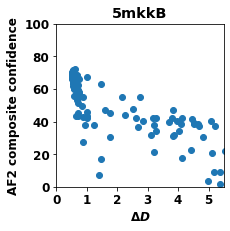

In [247]:
focus_pros = ['6s3qA','6gciA', '5aymA', '5c78A', '6e9nB', '6fhzA', '6qv1B']
focus_pros = ['5mkkB']
for pro in focus_pros:
# for pro in os.listdir(input_dir):
    print(pro)
    data = get_data(result_dir, pro)
    alternative_data = get_data(alternative_result_dir, pro)
    # print(data)
    # print(alternative_data)
    
    #  d<5
    CUTOFF = 5.5
    lower_5 = data[data[["d_in", "d_out"]] > CUTOFF]

    discriminator = discriminator_func(data["d_in"], data["d_out"], CUTOFF)
    alternative_discriminator = discriminator_func(alternative_data["d_in"], alternative_data["d_out"], CUTOFF)

    # plot_deltaD(data, alternative_data, result_dir, pro)
    # plot_data(discriminator, data['composite_score'], alternative_discriminator, alternative_data['composite_score'], result_dir, pro)
    plot_minD_composite_score(np.min(data[["d_in", "d_out"]], axis=1),data['composite_score'], result_dir, pro)
    # break


### Plot confidence scores of the two predicted structures using native or alternative structure as AF2's templates, respectively. 

#### distinguish inward-open structure derived sequences and outward-open structure derived sequences

In [3]:
in_out_file = '../../../dataset/output/mostdiff_files_seq_cluster70_manu_sel_in_out.txt'
f = open(in_out_file, 'r')
in_strucs = []
out_strucs = []
for l in f.readlines():
    in_str, out_str = l.split()[:2]
    in_str = in_str[:4] + in_str[-1]
    out_str = out_str[:4] + out_str[-1]
    in_strucs.append(in_str)
    out_strucs.append(out_str)

print(in_strucs)    
print(out_strucs)

['6xmsA', '6nc7A', '4q4aB', '5c78A', '6btxA', '5mkkB', '3qf4A', '6gciA', '6s3qA', '6bvgA', '6a6nA', '6fhzA', '6vs1A', '7l17A', '7mjsX', '6e9nB']
['6xmuA', '6nc9A', '6qv1B', '6hrcD', '5aymA', '6rajB', '6qv1C', '4c9jB', '6x3eA', '5iwsA', '7dqvA', '3vvsA', '6gv1A', '4m64A', '7n98A', '6e9oB']


In [2]:
# read protein names
pro_names_f = '../../../dataset/output/mostdiff_files_seq_cluster70_manu_sel_name.txt'
f = open(pro_names_f, 'r')
pro_names = []
for l in f.readlines():
    pro_names.append(l.split()[0])
print(pro_names)

['PF1', 'murJ', 'TM_0287', 'wlaB', 'slc39', 'TT_C0976', 'TM_0287', 'AAC3', 'SLC1A1', 'ptsG', 'CYME_CMD148C', 'PF0708', 'mdfA', 'melB', 'MFSD2A', 'A5U30_003247']


In [250]:
native_composite_scores_i2i = []
native_composite_scores_o2o = []

native_tmscore_out_i2i = []
native_tmscore_out_o2o = []

homo_composite_scores_i2o = []
homo_composite_scores_o2i = []

homo_tmscore_out_i2o = []
homo_tmscore_out_o2i = []

tm_scores = []
for seq_in in in_strucs:
    csv_ = os.path.join(alternative_result_dir, "results_"+seq_in+".csv")
    data = pd.read_csv(csv_)
    print(seq_in, data['plddt'].to_numpy(), data['ptm'].to_numpy())
    data['composite_score'] = data['tm_diff'] * data['plddt'] * data['ptm']
    # data['composite_score'] = data['plddt'] * data['ptm']
    native_composite_scores_i2i.append(float(data['composite_score'][0]))
    native_tmscore_out_i2i.append(float(data['tm_out'][0]))
    
    homo_composite_scores_i2o.append(float(data['composite_score'][1]))
    homo_tmscore_out_i2o.append(float(data['tm_out'][1]))    

    tm_scores.append(data['tm_diff'])
for seq_out in out_strucs:
    csv_ = os.path.join(alternative_result_dir, "results_"+seq_out+".csv")
    data = pd.read_csv(csv_)
    print(seq_out, data['plddt'].to_numpy(), data['ptm'].to_numpy())
    data['composite_score'] = data['tm_diff'] * data['plddt'] * data['ptm']
    # data['composite_score'] = data['plddt'] * data['ptm']
    native_composite_scores_o2o.append(float(data['composite_score'][0]))
    native_tmscore_out_o2o.append(float(data['tm_out'][0]))
    
    homo_composite_scores_o2i.append(float(data['composite_score'][1]))
    homo_tmscore_out_o2i.append(float(data['tm_out'][1]))      

    # tm_scores.append(data['tm_diff'])
# for csv_ in os.listdir(alternative_result_dir):
#     if csv_[-10:] == "deltaD.csv": continue
#     data = pd.read_csv(os.path.join(alternative_result_dir,csv_))
#     data['composite_score'] = data['tm_diff'] * data['plddt'] * data['ptm']
#     # tmscore_out = float(data['tm_out'])

#     # check in/out
#     seq_id = csv_[8:13]
#     if seq_id in in_strucs:
#         native_composite_scores_i2i.append(float(data['composite_score'][0]))
#         native_tmscore_out_i2i.append(float(data['tm_out'][0]))
        
#         homo_composite_scores_i2o.append(float(data['composite_score'][1]))
#         homo_tmscore_out_i2o.append(float(data['tm_out'][1]))
#     else:
#         print(seq_id)
#         native_composite_scores_o2o.append(float(data['composite_score'][0]))
#         native_tmscore_out_o2o.append(float(data['tm_out'][0]))
        
#         homo_composite_scores_o2i.append(float(data['composite_score'][1]))
#         homo_tmscore_out_o2i.append(float(data['tm_out'][1]))        

# print("native_composite_scores_i2i:")
# print(native_composite_scores_i2i)
# print("native_tmscore_out:")
# print(native_tmscore_out)


6xmsA [79.87013916 79.55063087] [0.79503236 0.78132716]
6nc7A [91.07510425 95.1442291 ] [0.90015409 0.92009383]
4q4aB [86.64189383 85.00237184] [0.69478222 0.69806869]
5c78A [86.17438842 86.27420127] [0.71020622 0.73159363]
6btxA [76.16553965 76.75442886] [0.77455506 0.75744058]
5mkkB [90.27809388 88.72576817] [0.75266395 0.74598509]
3qf4A [86.64118865 84.22457306] [0.68671619 0.66484182]
6gciA [91.75846189 86.36368403] [0.84587866 0.84233268]
6s3qA [87.4981319  80.67209366] [0.86076004 0.81198157]
6bvgA [91.542847   90.84948169] [0.85901689 0.86825128]
6a6nA [88.90095468 85.9626085 ] [0.79375566 0.80357401]
6fhzA [93.58752009 94.10756107] [0.89757494 0.92295765]
6vs1A [92.16491894 92.87410694] [0.8986131  0.89386892]
7l17A [91.52232456 75.08596769] [0.91133754 0.78215295]
7mjsX [83.59149109 79.61030266] [0.86001539 0.79846423]
6e9nB [90.3755909  90.38694398] [0.88654251 0.89364664]
6xmuA [77.52404452 80.48395843] [0.7377309 0.7986421]
6nc9A [94.84643056 90.56370597] [0.91892728 0.8986

In [251]:
tm_scores = np.array(tm_scores)
print(np.array(tm_scores))
print(np.sort(tm_scores, axis=0))

[[0.96554 0.96779]
 [0.95809 0.98013]
 [0.94564 0.90493]
 [0.83602 0.93912]
 [0.8876  0.88172]
 [0.96746 0.96671]
 [0.94967 0.9188 ]
 [0.97378 0.94665]
 [0.95606 0.94861]
 [0.97131 0.96319]
 [0.9591  0.95091]
 [0.96775 0.96227]
 [0.98372 0.98131]
 [0.98221 0.77012]
 [0.96434 0.9016 ]
 [0.94645 0.94884]]
[[0.83602 0.77012]
 [0.8876  0.88172]
 [0.94564 0.9016 ]
 [0.94645 0.90493]
 [0.94967 0.9188 ]
 [0.95606 0.93912]
 [0.95809 0.94665]
 [0.9591  0.94861]
 [0.96434 0.94884]
 [0.96554 0.95091]
 [0.96746 0.96227]
 [0.96775 0.96319]
 [0.97131 0.96671]
 [0.97378 0.96779]
 [0.98221 0.98013]
 [0.98372 0.98131]]


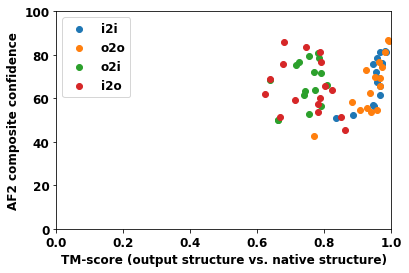

In [252]:
fig, ax = plt.subplots()
ax.scatter(native_tmscore_out_i2i, native_composite_scores_i2i, label='i2i')
ax.scatter(native_tmscore_out_o2o, native_composite_scores_o2o, label='o2o')
ax.scatter(homo_tmscore_out_o2i, homo_composite_scores_o2i, label='o2i')
ax.scatter(homo_tmscore_out_i2o, homo_composite_scores_i2o, label='i2o')
ax.legend()

ax.set_xlim(0,1)
ax.set_ylim(0,100)
ax.set_xlabel("TM-score (output structure vs. native structure)")
ax.set_ylabel("AF2 composite confidence")
plt.savefig("../output/tmscore_confidence.png", dpi=300, bbox_inches='tight')

In [253]:
# Pearson Correlation Coefficient
# rho = np.corrcoef(native_composite_scores, homo_composite_scores)
# print(rho)

In [254]:
print([abs(i - j) for i, j in zip(native_composite_scores_i2i,  homo_composite_scores_i2o)])
print([abs(i - j) for i, j in zip(native_composite_scores_o2o,  homo_composite_scores_o2i)])

[1.158104395225628, 7.256388364375169, 3.2286460719979075, 8.109302947037463, 1.102949036638151, 1.753305976963297, 5.054235616948169, 6.715516131149528, 9.867569073834623, 0.4041609958999999, 1.9931890452074725, 2.287413967634521, 0.006599776038868299, 36.69575138468561, 12.015285711127653, 0.8103112393158085]
[6.711719580829573, 9.574311064790805, 1.82021487724343, 5.726678459910964, 11.165833400733383, 0.034281109555209355, 2.559216193914118, 19.382701659821286, 10.018310726888217, 1.6104576564039093, 1.2898257244508429, 8.32663996036797, 0.5101383847462131, 36.772162962777855, 2.5066535657257134, 1.1829482868813699]


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

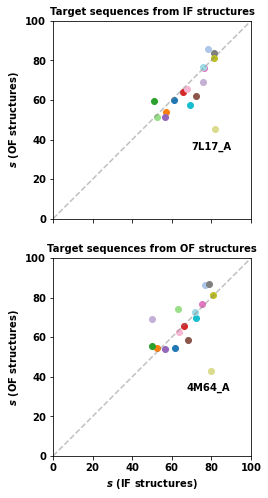

In [255]:
rcParams.update({'font.size': 10})
rcParams.update({'font.weight': 'bold'})
rcParams.update({"axes.labelweight": 'bold'})
rcParams.update({"axes.titleweight": 'bold'})

fig, axes = plt.subplots(2, 1, figsize=(4, 8), subplot_kw={'aspect': 'equal'}, sharex=True)

# Create a colormap to generate colors
cmap = plt.get_cmap('tab20')
colors = cmap(np.linspace(0, 1, len(native_composite_scores_i2i)))

axes[0].axline((0, 0), slope=1, ls='--', c='grey', alpha=0.5)
for i, (x, y) in enumerate(zip(native_composite_scores_i2i, homo_composite_scores_i2o)):
    axes[0].scatter(x, y, c=colors[i], alpha=1) # , label='inward'
# 7L17_A: the 7th one
axes[0].text(native_composite_scores_i2i[-3]-12, homo_composite_scores_i2o[-3]- 10, s='7L17_A')
axes[0].set_xlim(0,100)
axes[0].set_ylim(0,100)
# axes[0].set_xlabel(r"$s$ (IF structures)")
axes[0].set_ylabel(r"$s$ (OF structures)")
axes[0].set_title('Target sequences from IF structures', size=10)

axes[1].axline((0, 0), slope=1, ls='--', c='grey', alpha=0.5)
for k, (x, y) in enumerate(zip(homo_composite_scores_o2i, native_composite_scores_o2o)):
    axes[1].scatter(x,  y, c=colors[k]) # , label='outward'
# 4M64_A: the -5th one
axes[1].text(homo_composite_scores_o2i[-3]-12, native_composite_scores_o2o[-3] - 10, s='4M64_A')
axes[1].set_xlim(0,100)
axes[1].set_ylim(0,100)
# axes[1].set_xlabel(r"$s$ (IF structures)")
axes[1].set_ylabel(r"$s$ (OF structures)")
axes[1].set_title('Target sequences from OF structures', size=10)

plt.xlabel(r"$s$ (IF structures)")
# ax.set_title("AF composite confidence")
# plt.legend()
plt.savefig("../output/confidence_native_alternative.png", dpi=300, bbox_inches='tight')
plt.savefig("../output/confidence_native_alternative.pdf", bbox_inches='tight')

In [256]:
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

In [257]:
if_seq_engergies = []
of_seq_engergies = []

for if_, of_ in zip(in_strucs, out_strucs):
    data_in = pd.read_csv(os.path.join(alternative_result_dir,f"results_{if_}.csv"))
    data_in['composite_score'] = data_in['tm_diff'] * data_in['plddt'] * data_in['ptm']
    if_seq_engergies.append(float(data_in['composite_score'][0])) #i2i
    if_seq_engergies.append(float(data_in['composite_score'][1])) #i2o

    data_out = pd.read_csv(os.path.join(alternative_result_dir,f"results_{of_}.csv"))
    data_out['composite_score'] = data_out['tm_diff'] * data_out['plddt'] * data_out['ptm']
    of_seq_engergies.append(float(data_out['composite_score'][1])) #o2i
    of_seq_engergies.append(float(data_out['composite_score'][0])) #o2o

print(if_seq_engergies)
print(of_seq_engergies)
r2 = r2_score(if_seq_engergies, of_seq_engergies)

print(r2)

[61.31115791633968, 60.15305352111405, 78.54577796548479, 85.80216632985996, 56.92492462614066, 53.69627855414275, 51.165750155664156, 59.27505310270162, 52.36343305281889, 51.26048401618074, 65.73800396825054, 63.98469799128724, 56.50337748268219, 51.44914186573402, 75.5814193820844, 68.86590325093488, 72.00555887238319, 62.13798979854857, 76.38076034043223, 75.97659934453223, 67.67950134721305, 65.68631230200558, 81.29275414049562, 83.58016810813014, 81.4722840942696, 81.46568431823073, 81.9239064552143, 45.228155070528686, 69.32637247650423, 57.31108676537658, 75.83128047759406, 76.64159171690987]
[61.45865002094337, 54.74693044011379, 76.91939675430739, 86.49370781909819, 52.60086481493554, 54.42107969217897, 49.94971119787408, 55.676389657785045, 63.274222728078875, 74.44005612881226, 65.9203943729947, 65.8861132634395, 56.406421435746545, 53.84720524183243, 49.857399432646936, 69.24010109246822, 68.34990856835323, 58.33159784146501, 75.20458078432821, 76.81503844073212, 63.825673

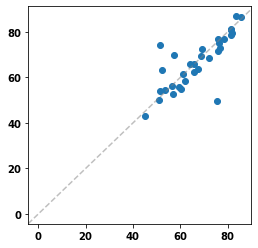

In [258]:
fig, ax = plt.subplots(1, figsize=(4,4))
ax.axline((0, 0), slope=1, ls='--', c='grey', alpha=0.5)
ax.scatter(if_seq_engergies, of_seq_engergies)

In [259]:
exp_deltaD = {}
with open('../../../dataset/output/deltaD', 'r') as f:
    for l in f.readlines():
        pro, deltaD = l.split()[:2]
        exp_deltaD[str(pro)] = float(deltaD)

# Delta D when AF2 input with only one state structure

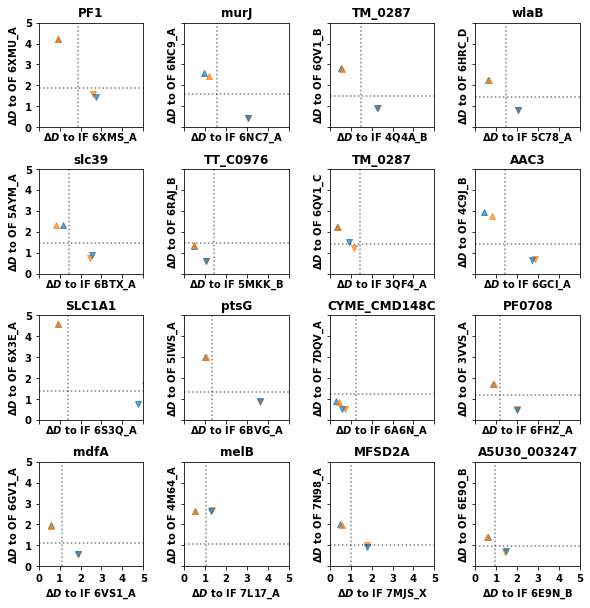

In [260]:
rcParams.update({'font.size': 10})
rcParams.update({'font.weight': 'bold'})
rcParams.update({"axes.labelweight": 'bold'})
rcParams.update({"axes.titleweight": 'bold'})

fig, axes = plt.subplots(4, 4, figsize=(10,10), sharex=True, sharey=True)
# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.4)

# read data
output_dir = '../output/eva_results_native_in_outward/results'
for k , (i_, o_, pro_name) in enumerate(zip(in_strucs, out_strucs, pro_names)):

    offical_i_ = i_.upper()[:4]+'_'+i_.upper()[-1]
    offical_o_ = o_.upper()[:4]+'_'+o_.upper()[-1]

    csv_i = os.path.join(output_dir, 'results_'+i_+'_deltaD.csv')
    csv_o = os.path.join(output_dir, 'results_'+o_+'_deltaD.csv')
    
    df_i = pd.read_csv(csv_i, header=0, index_col=None)
    df_o = pd.read_csv(csv_o, header=0, index_col=None)
    # print(df_i)
    # print(df_o)

    row_id = int(k/4)
    col_id = k%4

    ax = axes[row_id][col_id]

    ax.hlines(exp_deltaD[offical_i_]/2, linestyles=':', xmin=0, xmax=5, color='black', alpha=0.5)
    ax.vlines(exp_deltaD[offical_i_]/2, linestyles=':', ymin=0, ymax=5, color='black', alpha=0.5)
    
    df_i_na = df_i[df_i['decoy_id']=='na.pdb']
    df_o_na = df_o[df_o['decoy_id']=='na.pdb']
    df_i_al = df_i[df_i['decoy_id']==o_+'_ignorechain.pdb']
    df_o_al = df_o[df_o['decoy_id']==i_+'_ignorechain.pdb']   
    # input with IF template
    ax.scatter(df_i_na['d_in'], df_i_na['d_out'], c='C0', alpha=0.7, marker="^") # seq. from IF
    ax.scatter(df_o_al['d_in'], df_o_al['d_out'], c='C1', alpha=0.7, marker="^") # seq. from OF
    # input with OF template
    ax.scatter(df_o_na['d_in'], df_o_na['d_out'], c='C1', alpha=0.7, marker="v") # seq. from OF
    ax.scatter(df_i_al['d_in'], df_i_al['d_out'], c='C0', alpha=0.7, marker="v") # seq. from IF
    

    ax.set_xlabel(r"$\Delta{D}$ to IF "+offical_i_)
    ax.set_ylabel(r"$\Delta{D}$ to OF "+offical_o_)

    ax.set_title(pro_name)
    # Set aspect ratio to be equal
    ax.set_aspect('equal')
    # break

plt.xlim(0, 5)
plt.xticks([0,1,2,3,4,5])
plt.ylim(0, 5)

# ax.set_title("AF composite confidence")
# plt.legend()
plt.savefig("../output/deltaD_one_state.png", dpi=300, bbox_inches='tight')
plt.savefig("../output/deltaD_one_state.pdf", bbox_inches='tight')

## When both IF and OF structures as templates, the output state still have preference for a state.

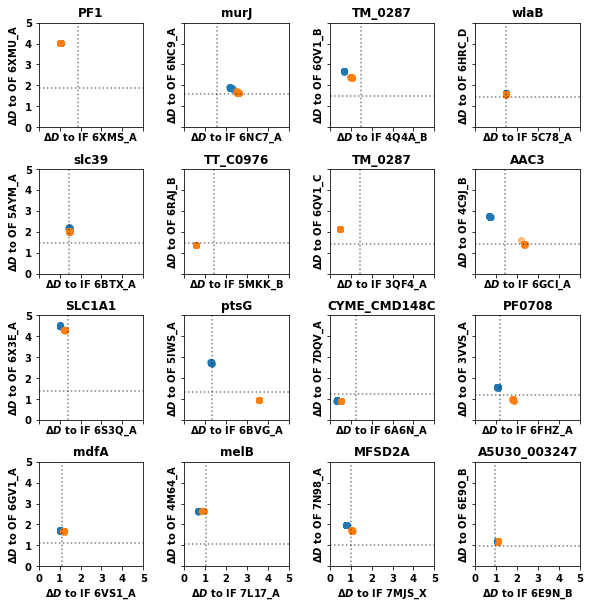

In [262]:
rcParams.update({'font.size': 10})
rcParams.update({'font.weight': 'bold'})
rcParams.update({"axes.labelweight": 'bold'})
rcParams.update({"axes.titleweight": 'bold'})

fig, axes = plt.subplots(4, 4, figsize=(10,10), sharex=True, sharey=True)
# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.4)
# read data
output_dir = '../output/eva_results_if_of_all_in/results'
for k , (i_, o_, pro_name) in enumerate(zip(in_strucs, out_strucs, pro_names)):

    offical_i_ = i_.upper()[:4]+'_'+i_.upper()[-1]
    offical_o_ = o_.upper()[:4]+'_'+o_.upper()[-1]

    csv_i = os.path.join(output_dir, 'results_'+i_+'_deltaD.csv')
    csv_o = os.path.join(output_dir, 'results_'+o_+'_deltaD.csv')
    
    df_i = pd.read_csv(csv_i, header=0, index_col=None)
    df_o = pd.read_csv(csv_o, header=0, index_col=None)
    # print(df_i)
    # print(df_o)

    row_id = int(k/4)
    col_id = k%4

    ax = axes[row_id][col_id]

    ax.hlines(exp_deltaD[offical_i_]/2, linestyles=':', xmin=0, xmax=5, color='black', alpha=0.5)
    ax.vlines(exp_deltaD[offical_i_]/2, linestyles=':', ymin=0, ymax=5, color='black', alpha=0.5)

    ax.scatter(df_i['d_in'], df_i['d_out'], c='C0', alpha=0.5)
    ax.scatter(df_o['d_in'], df_o['d_out'], c='C1', alpha=0.5)
    
    # ax.set_title(i_+' / '+o_)

    ax.set_xlabel(r"$\Delta{D}$ to IF "+offical_i_)
    ax.set_ylabel(r"$\Delta{D}$ to OF "+offical_o_)
    ax.set_title(pro_name)
    # Set aspect ratio to be equal
    ax.set_aspect('equal')# break

plt.xlim(0, 5)
plt.xticks([0,1,2,3,4,5])
plt.ylim(0, 5)

# ax.set_title("AF composite confidence")
# plt.legend()
plt.savefig("../output/deltaD_if_of_all_in.png", dpi=300, bbox_inches='tight')
plt.savefig("../output/deltaD_if_of_all_in.pdf", bbox_inches='tight')

## When no templates, $\Delta{D}$ 

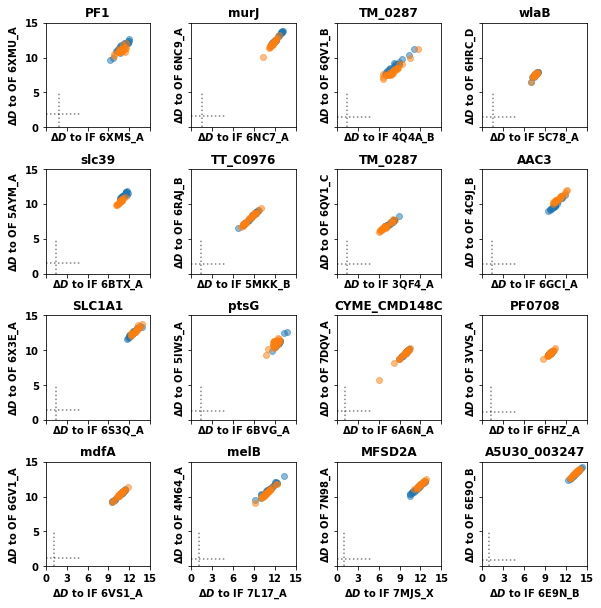

In [263]:
rcParams.update({'font.size': 10})
rcParams.update({'font.weight': 'bold'})
rcParams.update({"axes.labelweight": 'bold'})
rcParams.update({"axes.titleweight": 'bold'})

fig, axes = plt.subplots(4, 4, figsize=(10,10), sharex=True, sharey=True)
# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.4)
# read data
output_dir = '../output/eva_results_no_template/results'
for k , (i_, o_, pro_name) in enumerate(zip(in_strucs, out_strucs, pro_names)):

    offical_i_ = i_.upper()[:4]+'_'+i_.upper()[-1]
    offical_o_ = o_.upper()[:4]+'_'+o_.upper()[-1]

    csv_i = os.path.join(output_dir, 'results_'+i_+'_deltaD.csv')
    csv_o = os.path.join(output_dir, 'results_'+o_+'_deltaD.csv')
    
    df_i = pd.read_csv(csv_i, header=0, index_col=None)
    df_o = pd.read_csv(csv_o, header=0, index_col=None)
    # print(df_i)
    # print(df_o)

    row_id = int(k/4)
    col_id = k%4

    ax = axes[row_id][col_id]

    ax.hlines(exp_deltaD[offical_i_]/2, linestyles=':', xmin=0, xmax=5, color='black', alpha=0.5)
    ax.vlines(exp_deltaD[offical_i_]/2, linestyles=':', ymin=0, ymax=5, color='black', alpha=0.5)

    ax.scatter(df_i['d_in'], df_i['d_out'], c='C0', alpha=0.5)
    ax.scatter(df_o['d_in'], df_o['d_out'], c='C1', alpha=0.5)
    
    # ax.set_title(i_+' / '+o_)

    ax.set_xlabel(r"$\Delta{D}$ to IF "+offical_i_)
    ax.set_ylabel(r"$\Delta{D}$ to OF "+offical_o_)
    # break
    ax.set_title(pro_name)
    # Set aspect ratio to be equal
    ax.set_aspect('equal')
    
plt.xlim(0, 15)
# plt.xticks([0,1,2,3,4,5])
plt.xticks([0,3,6,9,12,15])
plt.ylim(0, 15)

# ax.set_title("AF composite confidence")
# plt.legend()
plt.savefig("../output/deltaD_no_template.png", dpi=300, bbox_inches='tight')
plt.savefig("../output/deltaD_no_template.pdf", bbox_inches='tight')

## When both IF and OF structures are input as templates and complete MSAs are given, ...

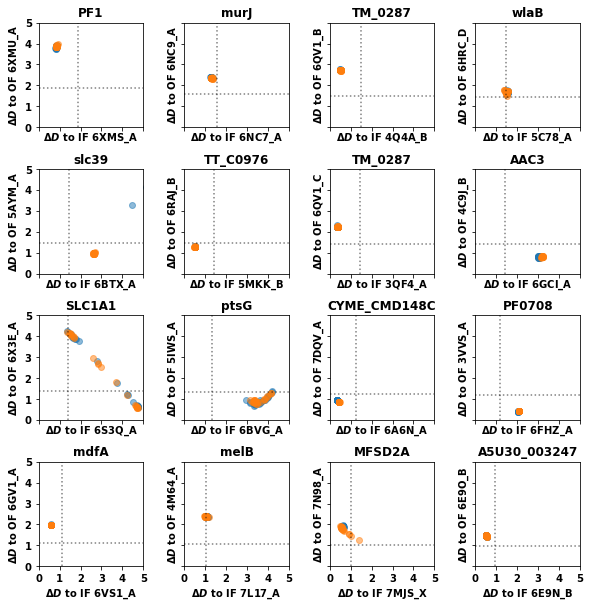

In [264]:
rcParams.update({'font.size': 10})
rcParams.update({'font.weight': 'bold'})
rcParams.update({"axes.labelweight": 'bold'})
rcParams.update({"axes.titleweight": 'bold'})

fig, axes = plt.subplots(4, 4, figsize=(10,10), sharex=True, sharey=True)
# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.4)
# read data
output_dir = '../output/eva_results_msa_if_of_all_in/results'
for k , (i_, o_, pro_name) in enumerate(zip(in_strucs, out_strucs, pro_names)):

    offical_i_ = i_.upper()[:4]+'_'+i_.upper()[-1]
    offical_o_ = o_.upper()[:4]+'_'+o_.upper()[-1]

    csv_i = os.path.join(output_dir, 'results_'+i_+'_deltaD.csv')
    csv_o = os.path.join(output_dir, 'results_'+o_+'_deltaD.csv')
    
    df_i = pd.read_csv(csv_i, header=0, index_col=None)
    df_o = pd.read_csv(csv_o, header=0, index_col=None)
    # print(df_i)
    # print(df_o)

    row_id = int(k/4)
    col_id = k%4

    ax = axes[row_id][col_id]

    ax.hlines(exp_deltaD[offical_i_]/2, linestyles=':', xmin=0, xmax=5, color='black', alpha=0.5)
    ax.vlines(exp_deltaD[offical_i_]/2, linestyles=':', ymin=0, ymax=5, color='black', alpha=0.5)

    ax.scatter(df_i['d_in'], df_i['d_out'], c='C0', alpha=0.5)
    ax.scatter(df_o['d_in'], df_o['d_out'], c='C1', alpha=0.5)
    
    # ax.set_title(i_+' / '+o_)
    ax.set_title(pro_name)
    # Set aspect ratio to be equal
    ax.set_aspect('equal')
    
    ax.set_xlabel(r"$\Delta{D}$ to IF "+offical_i_)
    ax.set_ylabel(r"$\Delta{D}$ to OF "+offical_o_)
    # break

plt.xlim(0, 5)
plt.xticks([0,1,2,3,4,5])
plt.ylim(0, 5) 

# ax.set_title("AF composite confidence")
# plt.legend()
plt.savefig("../output/deltaD_msa_if_of_all_in.png", dpi=300, bbox_inches='tight')
plt.savefig("../output/deltaD_msa_if_of_all_in.pdf", bbox_inches='tight')

## When only complete MSAs are given, ...

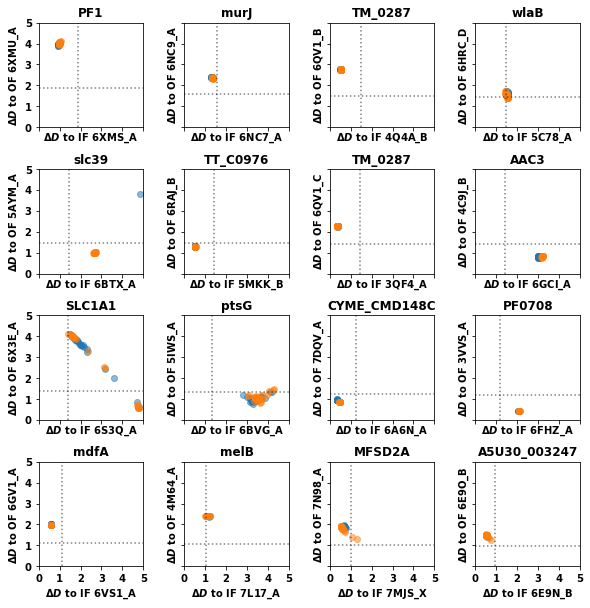

In [265]:
rcParams.update({'font.size': 10})
rcParams.update({'font.weight': 'bold'})
rcParams.update({"axes.labelweight": 'bold'})
rcParams.update({"axes.titleweight": 'bold'})

fig, axes = plt.subplots(4, 4, figsize=(10,10), sharex=True, sharey=True)
# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.4)
# read data
output_dir = '../output/eva_results_msa_in/results'
for k , (i_, o_, pro_name) in enumerate(zip(in_strucs, out_strucs, pro_names)):

    offical_i_ = i_.upper()[:4]+'_'+i_.upper()[-1]
    offical_o_ = o_.upper()[:4]+'_'+o_.upper()[-1]

    csv_i = os.path.join(output_dir, 'results_'+i_+'_deltaD.csv')
    csv_o = os.path.join(output_dir, 'results_'+o_+'_deltaD.csv')
    
    df_i = pd.read_csv(csv_i, header=0, index_col=None)
    df_o = pd.read_csv(csv_o, header=0, index_col=None)
    # print(df_i)
    # print(df_o)

    row_id = int(k/4)
    col_id = k%4

    ax = axes[row_id][col_id]

    ax.hlines(exp_deltaD[offical_i_]/2, linestyles=':', xmin=0, xmax=5, color='black', alpha=0.5)
    ax.vlines(exp_deltaD[offical_i_]/2, linestyles=':', ymin=0, ymax=5, color='black', alpha=0.5)

    ax.scatter(df_i['d_in'], df_i['d_out'], c='C0', alpha=0.5)
    ax.scatter(df_o['d_in'], df_o['d_out'], c='C1', alpha=0.5)
    
    # ax.set_title(i_+' / '+o_)
    ax.set_title(pro_name)
    # Set aspect ratio to be equal
    ax.set_aspect('equal')
    
    ax.set_xlabel(r"$\Delta{D}$ to IF "+offical_i_)
    ax.set_ylabel(r"$\Delta{D}$ to OF "+offical_o_)
    # break

plt.xlim(0, 5)
plt.xticks([0,1,2,3,4,5])
plt.ylim(0, 5) 

# ax.set_title("AF composite confidence")
# plt.legend()
plt.savefig("../output/deltaD_msa_in.png", dpi=300, bbox_inches='tight')
plt.savefig("../output/deltaD_msa_in.pdf", bbox_inches='tight')